In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import os
import shutil
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import teotil3 as teo
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


## 1. Create scenario data

In [4]:
st_yr, end_yr = 2013, 2022
orig_teo3_input_fold = r"/home/jovyan/shared/common/teotil3/annual_input_data"
totn_removal_eff_pct = 85

# Whether to delete the scenario folder first if it already exists
delete_existing = True

In [5]:
# Create scenario folder structure
scen_data_fold = f"/home/jovyan/shared/common/oslofjord_modelling/wastewater_scenarios/scen_totn_{totn_removal_eff_pct}pct_effect"
if os.path.exists(scen_data_fold) and delete_existing:
    shutil.rmtree(scen_data_fold)
os.makedirs(scen_data_fold)
os.makedirs(os.path.join(scen_data_fold, "teotil3_input_files"))

# Generate modified point data for scenario
print("Generating scenario data")
years = range(st_yr, end_yr + 1)
for year in years:
    print("    ", year)

    # Copy original data to scenario folder
    src_data_fold = f"/home/jovyan/shared/common/teotil3/point_data/{year}"
    scen_ann_data_fold = os.path.join(scen_data_fold, str(year))
    shutil.copytree(src_data_fold, scen_ann_data_fold)

    # Modify large wastewater data in scenario folder
    # 1. Assume all plants converted to 'Kjemisk-biologisk m/N-fjerning'
    type_xlsx = os.path.join(
        scen_ann_data_fold, f"avlop_stor_anlegg_{year}_treatment_types_bof_kof.xlsx"
    )
    type_df = pd.read_excel(type_xlsx, sheet_name="data")
    type_df["RENSPRINS"] = "Kjemisk-biologisk m/N-fjerning"
    type_df.to_excel(type_xlsx, sheet_name="data")

    # 2. Assume TOTN renseeffekt is equal to 'totn_removal_eff_pct'
    stan_xlsx = os.path.join(scen_ann_data_fold, f"avlop_stor_anlegg_{year}_raw.xlsx")
    stan_df = pd.read_excel(stan_xlsx, sheet_name=f"store_anlegg_{year}")
    stan_df["RENSEEFFEKT_N"] = totn_removal_eff_pct / 100
    stan_df["MENGDE_N_UT_kg"] = stan_df["MENGDE_N_INN_kg"] * (
        1 - stan_df["RENSEEFFEKT_N"]
    )
    stan_df.to_excel(stan_xlsx, sheet_name=f"store_anlegg_{year}")

Generating scenario data
     2013
     2014
     2015
     2016
     2017
     2018
     2019
     2020
     2021
     2022


## 2. Modify TEOTIL3 input files

In [6]:
%%capture

# Read supporting tables from db
reg_gdf = teo.io.get_regine_geodataframe(eng, 2022)
par_df = pd.read_sql("SELECT * FROM teotil3.output_param_definitions", eng)
conv_df = pd.read_sql("SELECT * FROM teotil3.input_output_param_conversion", eng)

par_list = [
    "totn_kg",
    "din_kg",
    "ton_kg",
    "totp_kg",
    "tdp_kg",
    "tpp_kg",
    "toc_kg",
    "ss_kg",
]

print("Patching model input files")
for year in years:
    print("    ", year)

    # Read scenario data for large wastewater
    scen_ann_data_fold = os.path.join(scen_data_fold, str(year))
    loc_gdf, df = teo.preprocessing.read_large_wastewater_and_industry_data(
        scen_ann_data_fold, year, eng
    )

    # Assign to regines
    loc_df = gpd.sjoin(
        loc_gdf,
        reg_gdf[["regine", "geometry"]],
        how="inner",
        op="within",
    )[["site_id", "sector", "regine"]]

    # Convert units and aggregate
    df = pd.merge(df, conv_df, how="left", on="in_par_id")
    df = pd.merge(df, par_df, how="left", on="out_par_id")
    df = pd.merge(df, loc_df, how="left", on="site_id")

    df = df.query("sector == 'Large wastewater'")

    df["name"] = df["name"] + "_" + df["unit"]
    df["value"] = df["value"] * df["factor"]
    df = (
        df[["regine", "name", "value"]]
        .groupby(["regine", "name"])
        .sum()
        .reset_index()
        .pivot(index="regine", columns="name", values="value")
    )
    cols = [f"large-wastewater_{col.lower()}" for col in df.columns]
    df.columns = cols
    df.columns.name = ""
    cols = [
        f"large-wastewater_{col}"
        for col in par_list
        if f"large-wastewater_{col}" in df.columns
    ]
    df = df[cols].copy()
    df = df.round(1)
    df.reset_index(inplace=True)

    # Read original TEOTIL3 input files
    in_csv = os.path.join(
        orig_teo3_input_fold, f"teotil3_input_data_nve2023_{year}.csv"
    )
    in_df = pd.read_csv(in_csv)

    # Patch input for large ww with scenario values
    drop_cols = [col for col in df.columns if col != "regine"]
    in_df.drop(columns=drop_cols, inplace=True)
    in_df = pd.merge(in_df, df, how="left", on="regine")
    for col in drop_cols:
        in_df[col] = in_df[col].fillna(0)

    # Save modified model input file
    scen_csv = os.path.join(
        scen_data_fold,
        "teotil3_input_files",
        f"teotil3_scenario_input_data_nve2023_{year}.csv",
    )
    in_df.to_csv(scen_csv, index=False)

## 3. Compare input files

In [7]:
for year in years:
    orig_csv = os.path.join(
        orig_teo3_input_fold, f"teotil3_input_data_nve2023_{year}.csv"
    )
    orig_df = pd.read_csv(orig_csv)

    scen_csv = os.path.join(
        scen_data_fold,
        "teotil3_input_files",
        f"teotil3_scenario_input_data_nve2023_{year}.csv",
    )
    scen_df = pd.read_csv(scen_csv)

    assert scen_df.shape == orig_df.shape

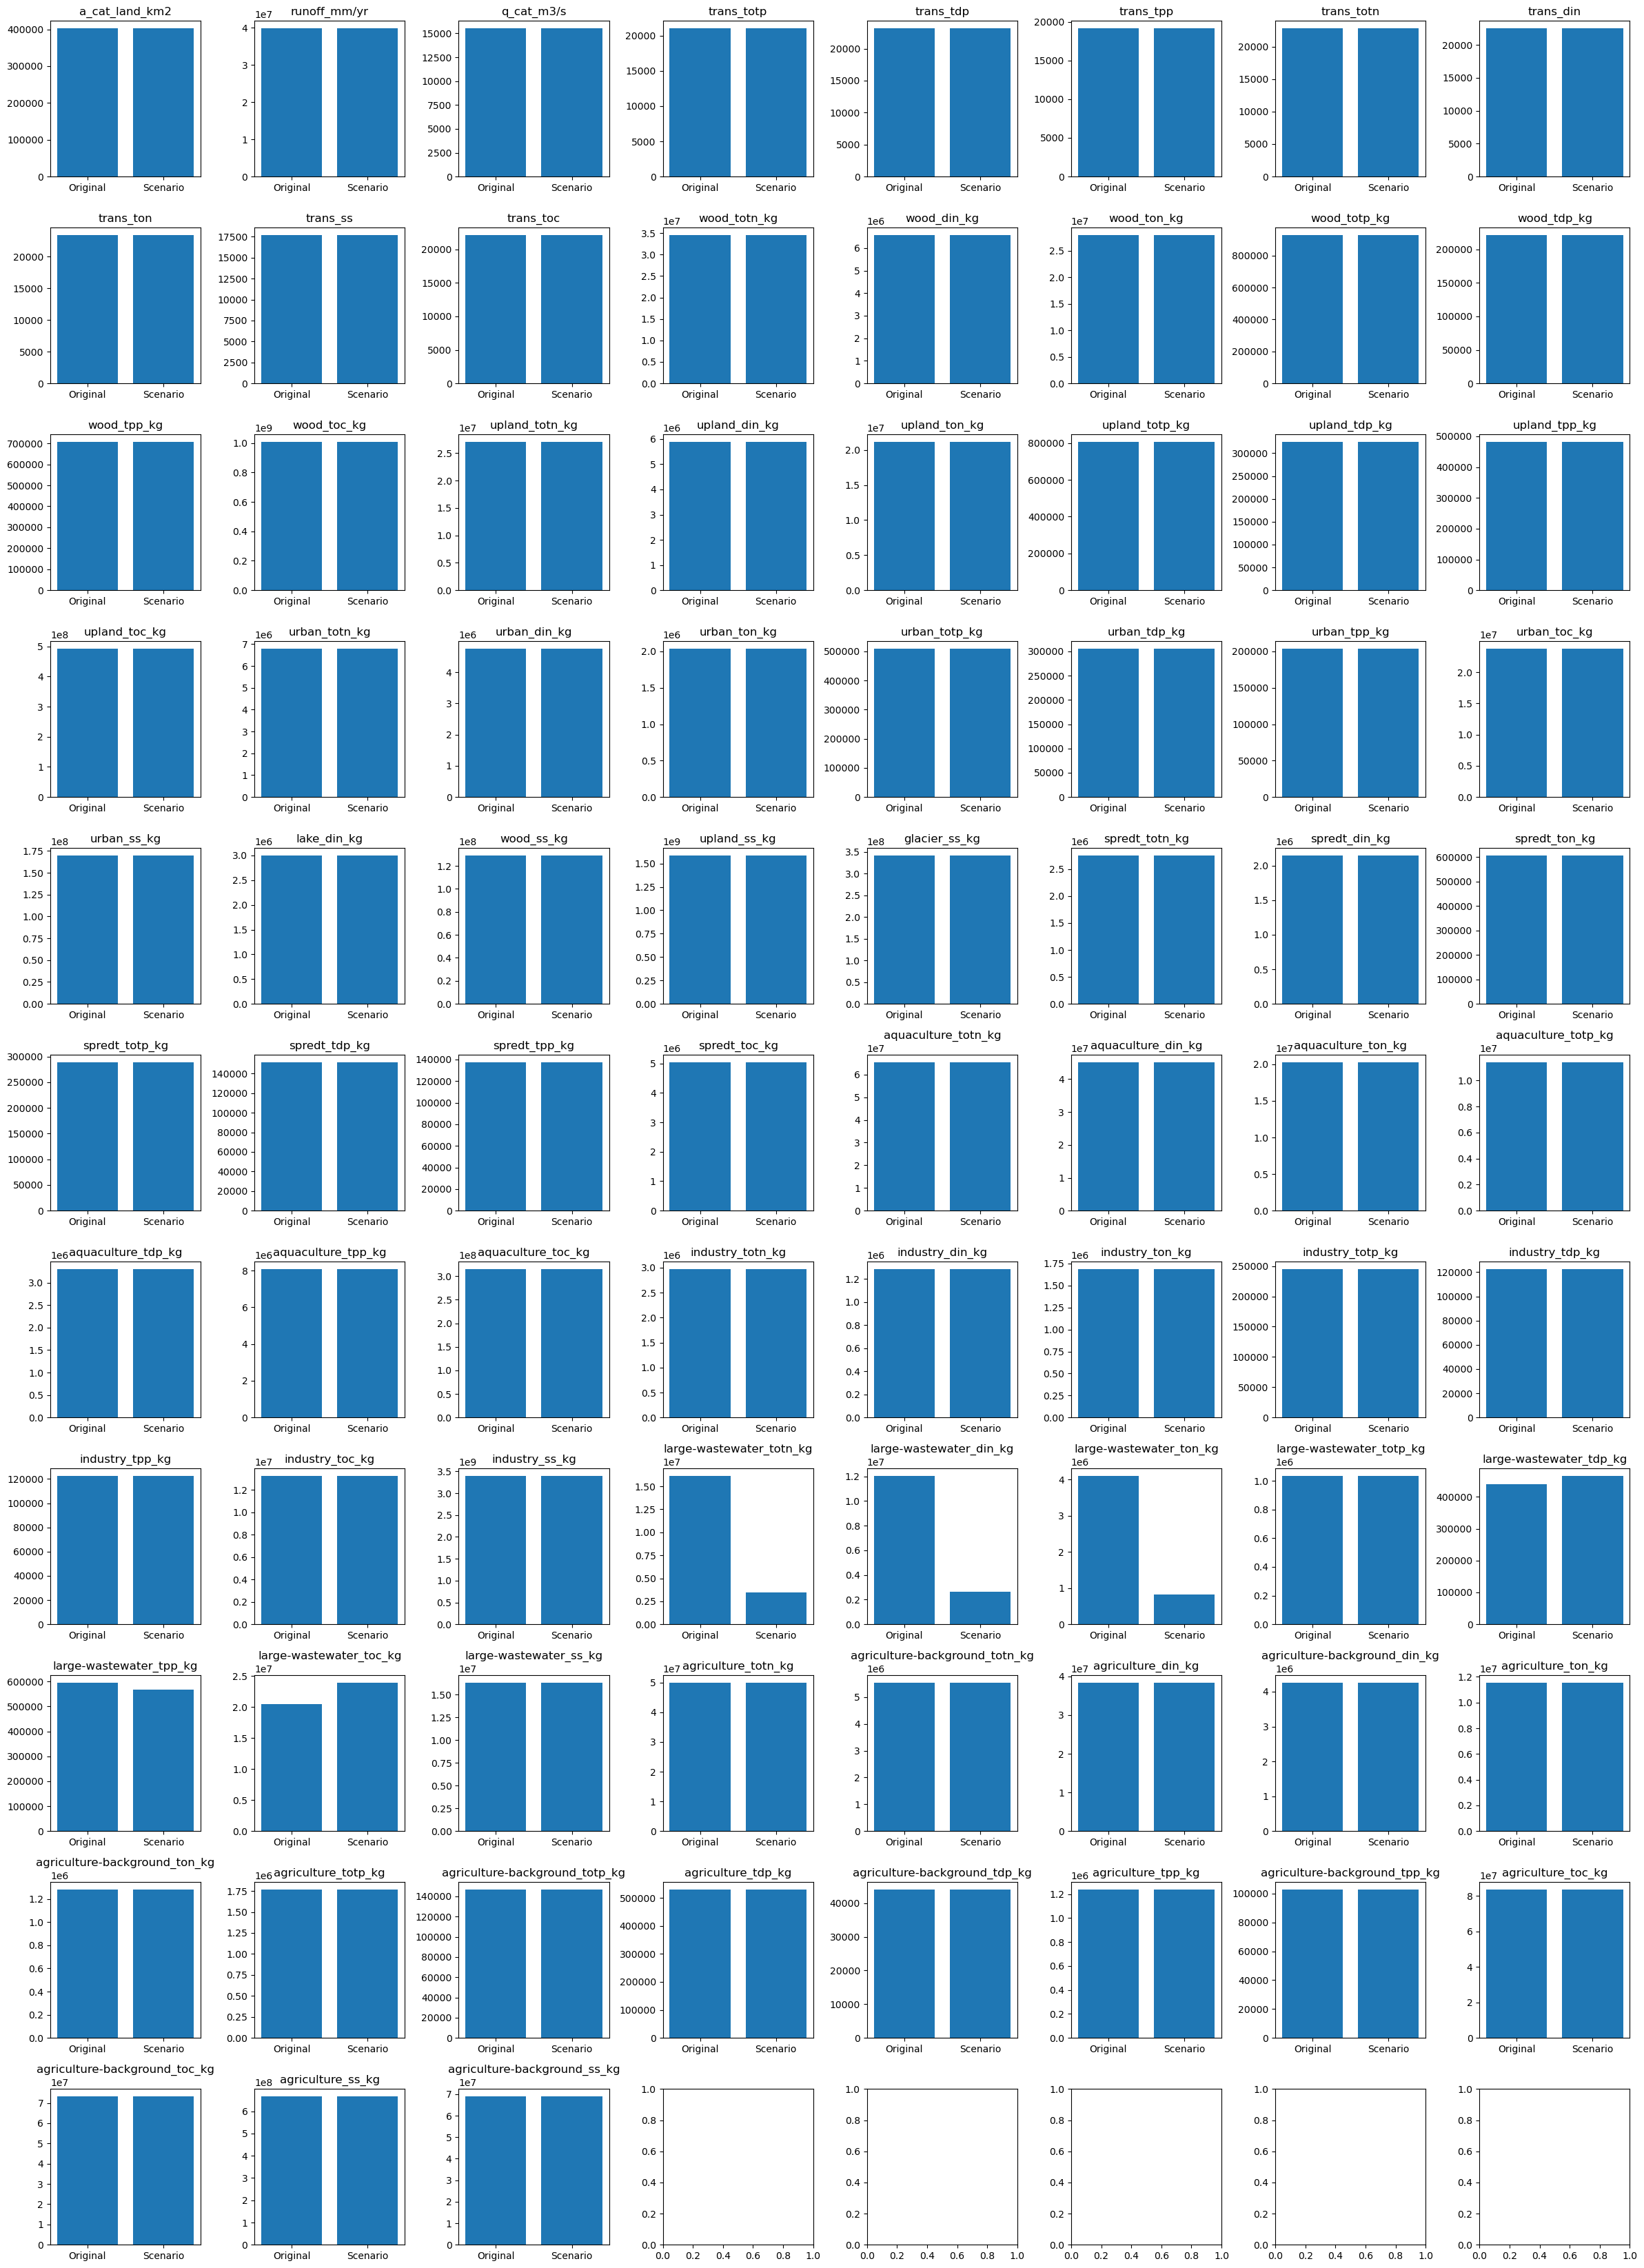

In [8]:
# Plot national total for each model input by source for the last year
# Just to check that only large wastewater has changed.
n_subplots = len(orig_df.select_dtypes(include="number").columns)
n_cols = 8
fig, axes = plt.subplots(
    int(n_subplots / n_cols) + 1,
    n_cols,
    figsize=(n_cols * 3, (int(n_subplots / n_cols) + 1) * 3),
)
axes = axes.flatten()
for i, col in enumerate(orig_df.select_dtypes(include="number").columns):
    axes[i].bar(["Original", "Scenario"], [orig_df.sum()[col], scen_df.sum()[col]])
    axes[i].set_title(col)

plt.tight_layout()

## 4. Run TEOTIL3

In [9]:
# Run TEOTIL3 with scenario data
df_list = []
for year in tqdm(years):
    scen_csv = os.path.join(
        scen_data_fold,
        "teotil3_input_files",
        f"teotil3_scenario_input_data_nve2023_{year}.csv",
    )
    g = teo.model.run_model(
        scen_csv,
        id_col="regine",
        next_down_col="regine_down",
        totals_from_subfracs=True,
    )
    res_df = teo.model.model_to_dataframe(
        g, id_col="regine", next_down_col="regine_down"
    )
    res_df["year"] = year
    df_list.append(res_df)
mod_df = pd.concat(df_list, axis="rows")

mod_csv = os.path.join(
    scen_data_fold, f"teo3_scenario_results_nve2023_{st_yr}-{end_yr}.csv"
)
mod_df.to_csv(mod_csv, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]